# Superintendants' Time to Close Completed WRs

In [1]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
import re
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# local utility functions
from utils.general_utils import (
    add_fiscal_year,
    compute_is_on_time,
    duration_in_days,
    set_pd_params,
    tidy_up_df,
    cast_dtypes,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
    compute_kpi_table_by_month,
)
from utils.sql_utils import mssql_engine, get_data_from_archibus
from utils.vis_utils import (
    set_plot_params,
    pointplot_with_barplot,
    simple_lineplot_from_df,
)
from utils.anonymization import split_names, replace_names

In [2]:
set_pd_params()
set_plot_params(12, 6)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
kpis_raw = get_data_from_archibus(mssql_engine(), "dash_benchmarks")
print(f"The work orders dataframe has {kpis_raw.shape[0]:,} rows.") 

The work orders dataframe has 108,090 rows.


In [4]:
# make sure each column is of the correct data type
wr_tidy = cast_dtypes(kpis_raw)
# basic cleaning
wr_tidy = tidy_up_df(wr_tidy)

print(f"The tidied work orders dataframe has {len(wr_tidy):,} rows.")
print(f"By tidying the data, we have removed {len(kpis_raw) - len(wr_tidy):,} rows.")

The tidied work orders dataframe has 108,090 rows.
By tidying the data, we have removed 0 rows.


## Superintendant's KPI

In [5]:
wr_tidy.head()

,wr_id,status,description,supervisor,date_completed,date_requested,date_closed,fy_request,fy_close,role_name,building_name,b_number,primary_type,problem_type,pm_group,calendar_month_request,calendar_month_close,days_to_completion,days_open,benchmark
0,19800,RMI,Need someone to make the necessary repairs to ...,NULL,NaT,2015-01-08,NaT,2015,NaN,GATEKEEPER-RESTRICTED - BOC,6400 Pulaski Highway Front Gate/Guard Office,B00166,HVAC,HVAC,None,2015-01,None,NaN,1597,30.0
1,21365,RMI,LABOR AND MATERIALS TO ADJUST OUTSIDE AIR DAMP...,NULL,NaT,2015-01-23,NaT,2015,NaN,GATEKEEPER - BOC,Howard Peters Rawlings Conservatory,B06225,HVAC,HVAC,None,2015-01,None,NaN,1582,30.0
2,24961,RMI,Please provide labor & materials to replace se...,NULL,NaT,2015-03-02,NaT,2015,NaN,GATEKEEPER - BOC,Oliver Senior Center,P00119,ELECTRICAL,ELEC/LIGHT,None,2015-03,None,NaN,1544,14.0
3,27301,I,The retaining wall that leads to the upper lot...,TERREL.CHESSON,2015-07-10,2015-03-16,NaT,2015,NaN,GATEKEEPER - BOC,Baltimore City Police North Eastern District,B00025,OTHER-EXTERNAL,OTHER,None,2015-03,None,116.0,1530,14.0
4,27353,Com,PROVIDE EMERGENCY REPAIR TO THE SPRINKLER SYST...,DARRYL.RAGIN,2016-12-18,2015-03-16,NaT,2015,NaN,GATEKEEPER - BOC,Mount Pleasant Ice Arena,B02055,HVAC,HVAC,None,2015-03,None,643.0,1530,30.0


In [6]:
wr_super = duration_in_days(
    wr_tidy, "days_from_completion_to_close", "date_completed", "date_closed"
)

wr_super = wr_super.dropna(subset=["days_from_completion_to_close"])
wr_super[
    ["date_requested", "date_completed", "date_closed", "days_from_completion_to_close"]
].sample(6)

,date_requested,date_completed,date_closed,days_from_completion_to_close
74351,2017-11-29,2017-11-29,2017-11-30 09:40:52.463,1.40
9561,2013-11-04,2013-11-05,2013-11-14 00:00:00.000,9.00
35958,2015-07-10,2015-07-10,2015-07-10 00:00:00.000,0.00
54398,2016-08-23,2016-08-23,2016-08-29 11:05:35.240,6.46
106083,2020-12-09,2020-12-13,2021-01-04 13:38:23.730,22.57
8874,2013-10-23,2013-11-04,2013-11-18 00:00:00.000,14.00


In [78]:
def compute_super_performance(df, index_var):
    df = df.copy()
    df = df.set_index(index_var)
    df = df.loc["2017-7-1":"2022-7-1"]
    table_df = df.groupby(pd.Grouper(freq="M"))["days_from_completion_to_close"].agg(
        ["mean", "median", "count"]
    )
    return table_df


perf = compute_super_performance(wr_super, "date_closed")

<ipython-input-78-bbbc9388eeca>:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc["2017-7-1":"2022-7-1"]


In [79]:
perf['date'] = perf.index
perf.head()

,mean,median,count,date
date_closed,,,,
2017-07-31,11.077711,7.62,734,2017-07-31
2017-08-31,10.941689,6.35,1024,2017-08-31
2017-09-30,16.059063,4.42,544,2017-09-30
2017-10-31,25.354559,9.35,1237,2017-10-31
2017-11-30,15.563133,3.42,581,2017-11-30


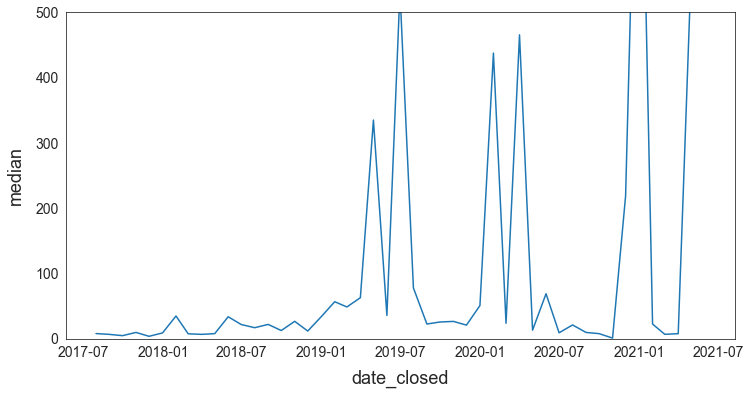

In [80]:
ax = sns.lineplot(data=perf, x=perf.index, y="median")

_ = ax.set(title='', ylim=(0, 500))

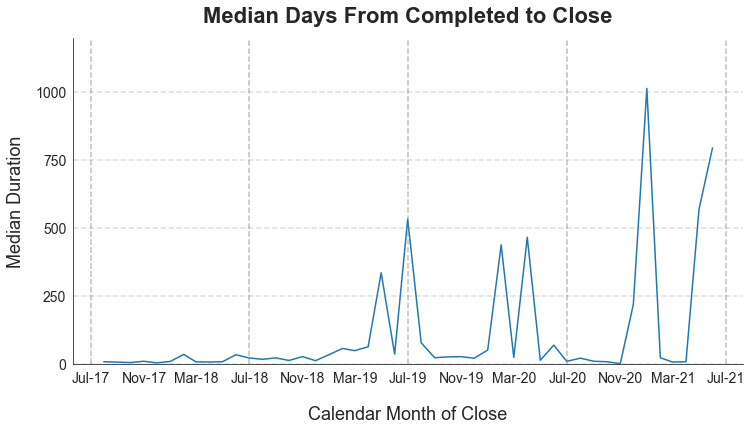

In [81]:
simple_lineplot_from_df(
    perf,
    "Median Days From Completed to Close",
    "Calendar Month of Close",
    "Median Duration",
    yaxis_freq=250,
    x='date_closed',
    y="median",
    ymax=1_200,
    legend_labels=None,
    legend_anchor=(0, 0),
    xtup=None,
)

In [64]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
from pathlib import Path

def pointplot_with_barplot(
    data,
    x,
    point_y,
    bar_y,
    title,
    yaxis_freq=25,
    ymax_point=105,
    ymax_bar=2000,
    ylabel_point="",
    ylabel_bar="",
    xlabel="Fiscal Year",
    yticklabels=None,
    interval=4,
):
    data = data.copy()
    data = data.reset_index(drop=False)
    sns.set_style("white")

    ax1 = sns.barplot(data=data, x=x, y=bar_y, color="lightgrey", alpha=0.5)
    
    _ = ax1.set(ylim=(0, ymax_bar), xlabel=xlabel, ylabel=ylabel_bar)

    ax2 = ax1.twinx()

    ax2 = sns.pointplot(
        data=data,
        x=x,
        y=point_y,
        color="indianred",
    )
    ax2.set(title=title, ylabel=ylabel_point, ylim=(0, ymax_point))

    for point in [t for t in range(0, ymax_point) if t % yaxis_freq == 0]:
        plt.axhline(point, linestyle="--", alpha=0.25, color="lightgrey")

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(yaxis_freq))
    if yticklabels:
        ax2.set_yticklabels(yticklabels)

    ax2.yaxis.set_label_position("left")
    ax2.yaxis.tick_left()
    ax1.yaxis.set_label_position("right")
    ax1.yaxis.tick_right()
    
    sns.despine()
    plt.show()

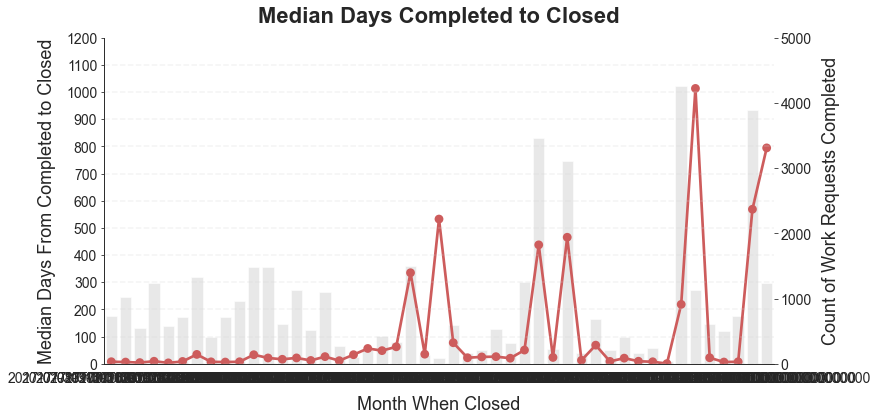

In [88]:
pointplot_with_barplot(
    perf,
    "date",
    "median",
    "count",
    "Median Days Completed to Closed",
    yaxis_freq=100,
    ymax_point=1_200,
    ymax_bar=5_000,
    ylabel_point="Median Days From Completed to Closed",
    ylabel_bar="Count of Work Requests Completed",
    xlabel="Month When Closed",
    yticklabels=None,
    interval=4,
)

In [52]:
perf.index

DatetimeIndex(['2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31', '2018-01-31', '2018-02-28',
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31', '2019-01-31', '2019-02-28',
               '2019-03-31', '2019-04-30', '2019-05-31', '2019-06-30',
               '2019-07-31', '2019-08-31', '2019-09-30', '2019-10-31',
               '2019-11-30', '2019-12-31', '2020-01-31', '2020-02-29',
               '2020-03-31', '2020-04-30', '2020-05-31', '2020-06-30',
               '2020-07-31', '2020-08-31', '2020-09-30', '2020-10-31',
               '2020-11-30', '2020-12-31', '2021-01-31', '2021-02-28',
               '2021-03-31', '2021-04-30', '2021-05-31'],
              dtype='datetime64[ns]', name='date_closed', freq='M')